In [1]:
# requirements.txt

# albumentations==1.0.3
# ipywidgets
# opencv-python==4.5.5.64
# Pillow==9.1.0
# pandas==1.3.4
# pycocotools==2.0.4
# seaborn==0.11.2
# segmentation-models-pytorch==0.2.0
# scipy==1.7.3
# webcolors==1.11.1

In [2]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns; sns.set()
import webcolors

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# from utils import label_accuracy_score, add_hist

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
device = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams['axes.grid'] = False
%matplotlib inline

1.7.1
True
Tesla V100-PCIE-32GB
1


In [3]:
batch_size = 4
num_epochs = 20
learning_rate = 0.0001

In [4]:
random_seed = 21

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # multiple GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
dataset_path  = '../data'
anns_file_path = dataset_path + '/' + 'train_all.json'

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

In [6]:
print(type(dataset))
print(dataset.keys())
print()
print(dataset['images'][0].keys())
print(dataset['images'][0].values())
print(dataset['images'][1000].values())
print()
print(dataset['categories'][0].keys())
print(dataset['categories'][0].values())
print()
print(dataset['annotations'][0].keys())

<class 'dict'>
dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

dict_keys(['license', 'url', 'file_name', 'height', 'width', 'date_captured', 'id'])
dict_values([0, None, 'batch_01_vt/0002.jpg', 512, 512, None, 0])
dict_values([0, None, 'batch_02_vt/0071.jpg', 512, 512, None, 1000])

dict_keys(['id', 'name', 'supercategory'])
dict_values([1, 'General trash', 'General trash'])

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])


In [7]:
cats = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

nr_cats = len(cats)
nr_anns = len(anns)
nr_imgs = len(imgs)

cats

[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

In [8]:
cat_names = []
supercat_name_last = ''
supercat_names = []
nr_supercats = 0
supercat_ids = {}

for cat in cats:
    
    cat_names.append(cat['name'])
    
    supercat_name = cat['supercategory']
    if supercat_name != supercat_name_last:
        supercat_names.append(supercat_name)
        
        supercat_ids[supercat_name] = nr_supercats
        supercat_name_last = supercat_name
        nr_supercats += 1
        
supercat_ids

{'General trash': 0,
 'Paper': 1,
 'Paper pack': 2,
 'Metal': 3,
 'Glass': 4,
 'Plastic': 5,
 'Styrofoam': 6,
 'Plastic bag': 7,
 'Battery': 8,
 'Clothing': 9}

In [9]:
anns[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

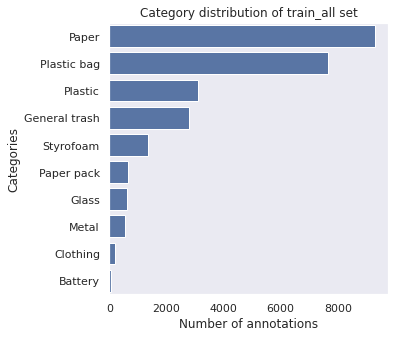

In [10]:
cat_histogram = np.zeros(nr_cats, dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1
    
fig, ax = plt.subplots(figsize=(5,5))

df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

plt.title("Category distribution of train_all set")
ax = sns.barplot(x='Number of annotations', y='Categories', data=df, label='Total', color='b')

In [11]:
df

,Categories,Number of annotations
1,Paper,9311
7,Plastic bag,7643
5,Plastic,3090
0,General trash,2782
6,Styrofoam,1343
2,Paper pack,659
4,Glass,610
3,Metal,562
9,Clothing,177
8,Battery,63


In [12]:
df_background = pd.DataFrame(['Background'], columns=['Categories'])
df_background

,Categories
0,Background


In [13]:
df = df.sort_index()
df = df_background.append(df, ignore_index=True)
df

,Categories,Number of annotations
0,Background,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


In [14]:
list(df.Categories)

['Background',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [15]:
category_names = list(df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return 'None'

class CustomDataLoader(Dataset):
    
    def __init__(self, data_dir, mode='train', transform=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # index -> id
        image_id = self.coco.getImgIds(imgIds=index)
        # id -> info
        image_infos = self.coco.loadImgs(image_id)[0]
        
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        
        # train, val
        if self.mode in ('train', 'val'):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)
            
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)
            
            masks = np.zeros((image_infos['height'], image_infos['width']))          
            anns = sorted(anns, key=lambda idx: idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i])==1] = pixel_value
            masks = masks.astype(np.int8)
            
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks) # ToTensorV2(): numpy(batch, height, width, channel) -> tensor(batch, channel, height, width)
                images = transformed['image']
                masks = transformed['mask']
            return images, masks, image_infos
        
        
        # test
        if self.mode=='test':
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed['image']
            return images, image_infos
                
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    ToTensorV2()
])

val_transform = A.Compose([
    ToTensorV2()
])

test_transform = A.Compose([
    ToTensorV2()
])

# transform = A.Compose([
#     ToTensorV2()
# ])

In [17]:
# train_all_path = dataset_path + '/train_all.json'
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# dataset = CustomDataLoader(data_dir=train_all_path, mode='train', transform=transform)
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# print(len(train_dataset), len(val_dataset), len(train_dataset)+len(val_dataset))

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)
print(len(train_dataset), len(val_dataset), len(train_dataset)+len(val_dataset))

test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)
print(len(test_dataset))

loading annotations into memory...
Done (t=3.95s)
creating index...
index created!
loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
2617 655 3272
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
624


In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=4,
    collate_fn=collate_fn
)

In [19]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [20]:
class_colormap.values

array([['Backgroud', 0, 0, 0],
       ['General trash', 192, 0, 128],
       ['Paper', 0, 128, 192],
       ['Paper pack', 0, 128, 64],
       ['Metal', 128, 0, 0],
       ['Glass', 64, 0, 128],
       ['Plastic', 64, 0, 192],
       ['Styrofoam', 192, 128, 64],
       ['Plastic bag', 192, 192, 128],
       ['Battery', 64, 64, 128],
       ['Clothing', 128, 0, 192]], dtype=object)

In [21]:
def create_trash_label_colormap():
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for i,(_, r, g, b) in enumerate(class_colormap.values):
        colormap[i] = [r, g, b]
    return colormap

cmap = create_trash_label_colormap()
print(type(cmap))
print(len(cmap))
cmap

<class 'numpy.ndarray'>
11


array([[  0,   0,   0],
       [192,   0, 128],
       [  0, 128, 192],
       [  0, 128,  64],
       [128,   0,   0],
       [ 64,   0, 128],
       [ 64,   0, 192],
       [192, 128,  64],
       [192, 192, 128],
       [ 64,  64, 128],
       [128,   0, 192]], dtype=uint8)

In [22]:
def label_to_color_image(label):
    
    if label.ndim!=2:
        raise ValueError('2D input expected')
        
    colormap = create_trash_label_colormap()
    
    if np.max(label)>=len(colormap):
        raise ValueError('Label value too large')
        
    return colormap[label]

In [23]:
images, masks, image_infos = next(iter(train_loader))

image_infos[0]

{'license': 0,
 'url': None,
 'file_name': 'batch_02_vt/0283.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 901}

torch.Size([3, 512, 512])
torch.Size([512, 512])
[{0, 'Background'}, {1, 'General trash'}, {2, 'Paper'}, {'Plastic', 6}, {8, 'Plastic bag'}]


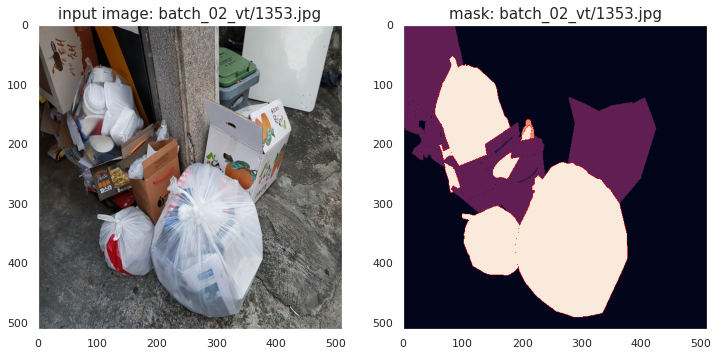

In [24]:
# train_loader

for images, masks, image_infos in train_loader:
    image_info = image_infos[0]
    image = images[0]
    mask = masks[0]
    break
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

print(image.shape)
print(mask.shape)
print([{int(i), category_names[int(i)]} for i in list(np.unique(mask))])

ax1.imshow(image.permute([1, 2, 0]))
ax1.set_title(f"input image: {image_info['file_name']}", fontsize=15)

ax2.imshow(mask)
ax2.set_title(f"mask: {image_info['file_name']}", fontsize=15)

plt.show()

torch.Size([3, 512, 512])
torch.Size([512, 512])
[{0, 'Background'}, {'Glass', 5}, {'Plastic', 6}, {8, 'Plastic bag'}]


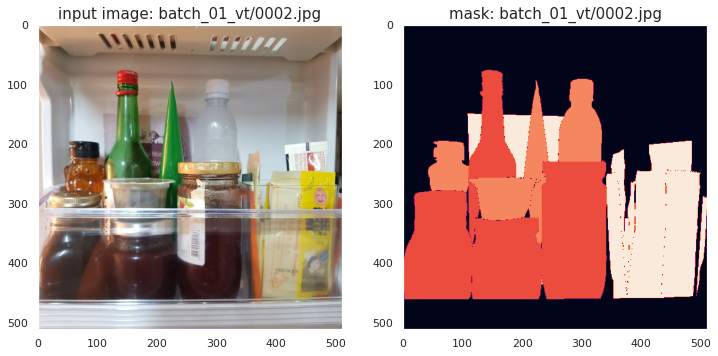

In [25]:
# val_loader

for images, masks, image_infos in val_loader:
    image_info = image_infos[0]
    image = images[0]
    mask = masks[0]
    break
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

print(image.shape)
print(mask.shape)
print([{int(i), category_names[int(i)]} for i in list(np.unique(mask))])

ax1.imshow(image.permute([1, 2, 0]))
ax1.set_title(f"input image: {image_info['file_name']}", fontsize=15)

ax2.imshow(mask)
ax2.set_title(f"mask: {image_info['file_name']}", fontsize=15)

plt.show()

torch.Size([3, 512, 512])


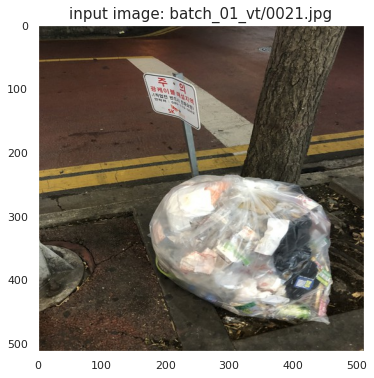

In [26]:
# test_loader

for images, image_infos in test_loader:
    image_info = image_infos[0]
    image = images[0]
    break
    
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

print(image.shape)

ax1.imshow(image.permute([1, 2, 0]))
ax1.set_title(f"input image: {image_info['file_name']}", fontsize=15)

plt.show()

In [27]:
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models

# model = models.segmentation.fcn_resnet50(pretrained=True)

# # model

# # FCN(
# #   (backbone)
# #   (classifier): FCNHead(
# #     (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# #     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
# #     (2): ReLU()
# #     (3): Dropout(p=0.1, inplace=False)
# #     (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
# #   )
# # )
    
# model.classifier[4] = nn.Conv2d(512, 11, kernel_size=1)

In [28]:
# x = torch.randn([2, 3, 512, 512])
# print(f"input shape: {x.shape}")

# out = model(x)['out']
# print(f"output shape: {out.size()}")

In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet3Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=11):
        super(UNet3Plus, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        
        # Encoder
        
        # e1
        self.e1_conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.e1_bn1 = nn.BatchNorm2d(64)
        self.e1_relu1 = nn.ReLU(inplace=True)
        self.e1_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.e1_bn2 = nn.BatchNorm2d(64)
        self.e1_relu2 = nn.ReLU(inplace=True)
        
        # e2
        self.e2_maxpool = nn.MaxPool2d(kernel_size=2)
        self.e2_conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.e2_bn1 = nn.BatchNorm2d(128)
        self.e2_relu1 = nn.ReLU(inplace=True)
        self.e2_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.e2_bn2 = nn.BatchNorm2d(128)
        self.e2_relu2 = nn.ReLU(inplace=True)
        
        # e3
        self.e3_maxpool = nn.MaxPool2d(kernel_size=2)
        self.e3_conv1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.e3_bn1 = nn.BatchNorm2d(256)
        self.e3_relu1 = nn.ReLU(inplace=True)
        self.e3_conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.e3_bn2 = nn.BatchNorm2d(256)
        self.e3_relu2 = nn.ReLU(inplace=True)
        
        # e4
        self.e4_maxpool = nn.MaxPool2d(kernel_size=2)
        self.e4_conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.e4_bn1 = nn.BatchNorm2d(512)
        self.e4_relu1 = nn.ReLU(inplace=True)
        self.e4_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.e4_bn2 = nn.BatchNorm2d(512)
        self.e4_relu2 = nn.ReLU(inplace=True)
        
        # e5
        self.e5_maxpool = nn.MaxPool2d(kernel_size=2)
        self.e5_conv1 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.e5_bn1 = nn.BatchNorm2d(1024)
        self.e5_relu1 = nn.ReLU(inplace=True)
        self.e5_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.e5_bn2 = nn.BatchNorm2d(1024)
        self.e5_relu2 = nn.ReLU(inplace=True)

        
        # Decoder
        
        # e1 -> d4
        self.d4_e1_maxpool = nn.MaxPool2d(kernel_size=8, stride=8, ceil_mode=True)
        self.d4_e1_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.d4_e1_bn = nn.BatchNorm2d(64)
        self.d4_e1_relu = nn.ReLU(inplace=True)
        # e2 -> d4
        self.d4_e2_maxpool = nn.MaxPool2d(kernel_size=4, stride=4, ceil_mode=True)
        self.d4_e2_conv = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.d4_e2_bn = nn.BatchNorm2d(64)
        self.d4_e2_relu = nn.ReLU(inplace=True)
        # e3 -> d4
        self.d4_e3_maxpool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.d4_e3_conv = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.d4_e3_bn = nn.BatchNorm2d(64)
        self.d4_e3_relu = nn.ReLU(inplace=True)        
        # e4 -> d4
        self.d4_e4_conv = nn.Conv2d(512, 64, kernel_size=3, stride=1, padding=1)
        self.d4_e4_bn = nn.BatchNorm2d(64)
        self.d4_e4_relu = nn.ReLU(inplace=True)  
        # e5 -> d4
        self.d4_e5_upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.d4_e5_conv = nn.Conv2d(1024, 64, kernel_size=3, stride=1, padding=1)
        self.d4_e5_bn = nn.BatchNorm2d(64)
        self.d4_e5_relu = nn.ReLU(inplace=True)  
        # d4
        self.d4_conv = nn.Conv2d(320, 320, kernel_size=3, stride=1, padding=1)
        self.d4_bn = nn.BatchNorm2d(320)
        self.d4_relu = nn.ReLU(inplace=True)  
        
        
        # e1 -> d3
        self.d3_e1_maxpool = nn.MaxPool2d(kernel_size=4, stride=4, ceil_mode=True)
        self.d3_e1_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.d3_e1_bn = nn.BatchNorm2d(64)
        self.d3_e1_relu = nn.ReLU(inplace=True)
        # e2 -> d3
        self.d3_e2_maxpool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.d3_e2_conv = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.d3_e2_bn = nn.BatchNorm2d(64)
        self.d3_e2_relu = nn.ReLU(inplace=True)
        # e3 -> d3
        self.d3_e3_conv = nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1)
        self.d3_e3_bn = nn.BatchNorm2d(64)
        self.d3_e3_relu = nn.ReLU(inplace=True)  
        # d4 -> d3
        self.d3_d4_upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.d3_d4_conv = nn.Conv2d(320, 64, kernel_size=3, stride=1, padding=1)
        self.d3_d4_bn = nn.BatchNorm2d(64)
        self.d3_d4_relu = nn.ReLU(inplace=True)  
        # e5 -> d3
        self.d3_e5_upsample = nn.Upsample(scale_factor=4, mode='bilinear')
        self.d3_e5_conv = nn.Conv2d(1024, 64, kernel_size=3, stride=1, padding=1)
        self.d3_e5_bn = nn.BatchNorm2d(64)
        self.d3_e5_relu = nn.ReLU(inplace=True)  
        # d3
        self.d3_conv = nn.Conv2d(320, 320, kernel_size=3, stride=1, padding=1)
        self.d3_bn = nn.BatchNorm2d(320)
        self.d3_relu = nn.ReLU(inplace=True) 
        
        
        # e1 -> d2
        self.d2_e1_maxpool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.d2_e1_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.d2_e1_bn = nn.BatchNorm2d(64)
        self.d2_e1_relu = nn.ReLU(inplace=True)
        # e2 -> d2
        self.d2_e2_conv = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.d2_e2_bn = nn.BatchNorm2d(64)
        self.d2_e2_relu = nn.ReLU(inplace=True)  
        # d3 -> d2
        self.d2_d3_upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.d2_d3_conv = nn.Conv2d(320, 64, kernel_size=3, stride=1, padding=1)
        self.d2_d3_bn = nn.BatchNorm2d(64)
        self.d2_d3_relu = nn.ReLU(inplace=True) 
        # d4 -> d2
        self.d2_d4_upsample = nn.Upsample(scale_factor=4, mode='bilinear')
        self.d2_d4_conv = nn.Conv2d(320, 64, kernel_size=3, stride=1, padding=1)
        self.d2_d4_bn = nn.BatchNorm2d(64)
        self.d2_d4_relu = nn.ReLU(inplace=True) 
        # e5 -> d2
        self.d2_e5_upsample = nn.Upsample(scale_factor=8, mode='bilinear')
        self.d2_e5_conv = nn.Conv2d(1024, 64, kernel_size=3, stride=1, padding=1)
        self.d2_e5_bn = nn.BatchNorm2d(64)
        self.d2_e5_relu = nn.ReLU(inplace=True) 
        # d2
        self.d2_conv = nn.Conv2d(320, 320, kernel_size=3, stride=1, padding=1)
        self.d2_bn = nn.BatchNorm2d(320)
        self.d2_relu = nn.ReLU(inplace=True) 
        
        
        # e1 -> d1
        self.d1_e1_conv = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.d1_e1_bn = nn.BatchNorm2d(64)
        self.d1_e1_relu = nn.ReLU(inplace=True) 
        # d2 -> d1
        self.d1_d2_upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.d1_d2_conv = nn.Conv2d(320, 64, kernel_size=3, stride=1, padding=1)
        self.d1_d2_bn = nn.BatchNorm2d(64)
        self.d1_d2_relu = nn.ReLU(inplace=True) 
        # d3 -> d1
        self.d1_d3_upsample = nn.Upsample(scale_factor=4, mode='bilinear')
        self.d1_d3_conv = nn.Conv2d(320, 64, kernel_size=3, stride=1, padding=1)
        self.d1_d3_bn = nn.BatchNorm2d(64)
        self.d1_d3_relu = nn.ReLU(inplace=True) 
        # d4 -> d1
        self.d1_d4_upsample = nn.Upsample(scale_factor=8, mode='bilinear')
        self.d1_d4_conv = nn.Conv2d(320, 64, kernel_size=3, stride=1, padding=1)
        self.d1_d4_bn = nn.BatchNorm2d(64)
        self.d1_d4_relu = nn.ReLU(inplace=True) 
        # e5 -> d1
        self.d1_e5_upsample = nn.Upsample(scale_factor=16, mode='bilinear')
        self.d1_e5_conv = nn.Conv2d(1024, 64, kernel_size=3, stride=1, padding=1)
        self.d1_e5_bn = nn.BatchNorm2d(64)
        self.d1_e5_relu = nn.ReLU(inplace=True) 
        # d1
        self.d1_conv = nn.Conv2d(320, 320, kernel_size=3, stride=1, padding=1)
        self.d1_bn = nn.BatchNorm2d(320)
        self.d1_relu = nn.ReLU(inplace=True) 
        
        
        # Output
        
        self.output = nn.Conv2d(320, self.out_channels, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        
        e1 = self.e1_relu2(self.e1_bn2(self.e1_conv2(self.e1_relu1(self.e1_bn1(self.e1_conv1(x))))))
        
        e2 = self.e2_relu2(self.e2_bn2(self.e2_conv2(self.e2_relu1(self.e2_bn1(self.e2_conv1(self.e2_maxpool(e1)))))))
        
        e3 = self.e3_relu2(self.e3_bn2(self.e3_conv2(self.e3_relu1(self.e3_bn1(self.e3_conv1(self.e3_maxpool(e2)))))))
        
        e4 = self.e4_relu2(self.e4_bn2(self.e4_conv2(self.e4_relu1(self.e4_bn1(self.e4_conv1(self.e4_maxpool(e3)))))))
        
        e5 = self.e5_relu2(self.e5_bn2(self.e5_conv2(self.e5_relu1(self.e5_bn1(self.e5_conv1(self.e5_maxpool(e4)))))))
        
        d4_e1 = self.d4_e1_relu(self.d4_e1_bn(self.d4_e1_conv(self.d4_e1_maxpool(e1))))
        d4_e2 = self.d4_e2_relu(self.d4_e2_bn(self.d4_e2_conv(self.d4_e2_maxpool(e2))))
        d4_e3 = self.d4_e3_relu(self.d4_e3_bn(self.d4_e3_conv(self.d4_e3_maxpool(e3))))
        d4_e4 = self.d4_e4_relu(self.d4_e4_bn(self.d4_e4_conv(e4)))
        d4_e5 = self.d4_e5_relu(self.d4_e5_bn(self.d4_e5_conv(self.d4_e5_upsample(e5))))
        d4 = self.d4_relu(self.d4_bn(self.d4_conv(torch.cat((d4_e1, d4_e2, d4_e3, d4_e4, d4_e5), 1))))
        
        d3_e1 = self.d3_e1_relu(self.d3_e1_bn(self.d3_e1_conv(self.d3_e1_maxpool(e1))))
        d3_e2 = self.d3_e2_relu(self.d3_e2_bn(self.d3_e2_conv(self.d3_e2_maxpool(e2))))
        d3_e3 = self.d3_e3_relu(self.d3_e3_bn(self.d3_e3_conv(e3)))
        d3_d4 = self.d3_d4_relu(self.d3_d4_bn(self.d3_d4_conv(self.d3_d4_upsample(d4))))
        d3_e5 = self.d3_e5_relu(self.d3_e5_bn(self.d3_e5_conv(self.d3_e5_upsample(e5))))
        d3 = self.d3_relu(self.d3_bn(self.d3_conv(torch.cat((d3_e1, d3_e2, d3_e3, d3_d4, d3_e5), 1))))
        
        d2_e1 = self.d2_e1_relu(self.d2_e1_bn(self.d2_e1_conv(self.d2_e1_maxpool(e1))))
        d2_e2 = self.d2_e2_relu(self.d2_e2_bn(self.d2_e2_conv(e2)))
        d2_d3 = self.d2_d3_relu(self.d2_d3_bn(self.d2_d3_conv(self.d2_d3_upsample(d3))))
        d2_d4 = self.d2_d4_relu(self.d2_d4_bn(self.d2_d4_conv(self.d2_d4_upsample(d4))))
        d2_e5 = self.d2_e5_relu(self.d2_e5_bn(self.d2_e5_conv(self.d2_e5_upsample(e5))))
        d2 = self.d2_relu(self.d2_bn(self.d2_conv(torch.cat((d2_e1, d2_e2, d2_d3, d2_d4, d2_e5), 1))))
        
        d1_e1 = self.d1_e1_relu(self.d1_e1_bn(self.d1_e1_conv(e1)))
        d1_d2 = self.d1_d2_relu(self.d1_d2_bn(self.d1_d2_conv(self.d1_d2_upsample(d2))))
        d1_d3 = self.d1_d3_relu(self.d1_d3_bn(self.d1_d3_conv(self.d1_d3_upsample(d3))))
        d1_d4 = self.d1_d4_relu(self.d1_d4_bn(self.d1_d4_conv(self.d1_d4_upsample(d4))))
        d1_e5 = self.d1_e5_relu(self.d1_e5_bn(self.d1_e5_conv(self.d1_e5_upsample(e5))))
        d1 = self.d1_relu(self.d1_bn(self.d1_conv(torch.cat((d1_e1, d1_d2, d1_d3, d1_d4, d1_e5), 1))))
        
        output = self.output(d1)
        
        return F.sigmoid(output)

In [30]:
model = UNet3Plus(in_channels=3, out_channels=11)

x = torch.randn([2, 3, 512, 512])
print("input shape:", x.shape)

out = model(x).to(device)
print("output shape:", out.size())

model = model.to(device)

input shape: torch.Size([2, 3, 512, 512])
output shape: torch.Size([2, 11, 512, 512])


In [31]:
# from torchsummary import summary

# summary(model, input_size=(3, 512, 512), device='cpu')

In [32]:
# utils.py

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true>=0)&(label_true<n_class)
    hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class**2).reshape(n_class, n_class)
    return hist

def label_accuracy_score(hist):
    acc = np.diag(hist).sum()/hist.sum()
    
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist)/hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist)/(hist.sum(axis=1)+hist.sum(axis=0)-np.diag(hist))
    mean_iu = np.nanmean(iu)
    
    freq = hist.sum(axis=1)/hist.sum()
    fwavacc = (freq[freq>0]*iu[freq>0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu

def add_hist(hist, label_trues, label_preds, n_class):
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    return hist

In [33]:
def train(num_epochs, model, data_loader, val_loader, criterion, optmizer, saved_dir, val_every, device):
    
    print("Start train")
    
    n_class = 11
    best_loss = 9999999
    
    for epoch in range(num_epochs):
        model.train()
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)
            masks = torch.stack(masks).long()
            
            images = images.to(device)
            masks = masks.to(device)
            model = model.to(device)
            
            # outputs = model(images)['out']
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optmizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            if (step+1)%25==0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Loss: {round(loss.item(), 4)}, mIoU: {round(mIoU, 4)}")
                
        if (epoch+1)%val_every==0:
            avrg_loss = validation(epoch+1, model, val_loader, criterion, device)
            if avrg_loss<best_loss:
                print(f"Best performance at epoch: {epoch+1}")
                print(f"Model saved in {saved_dir}")
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [34]:
def validation(epoch, model, data_loader, criterion, device):
    
    print(f"Start validation #{epoch}")
    
    model.eval()
    
    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)
            masks = torch.stack(masks).long()
            
            images = images.to(device)
            masks = masks.to(device)
            model = model.to(device)
            
            # outputs = model(images)['out']
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes: round(IoU, 4)} for IoU, classes in zip(IoU, df['Categories'])]
        
        avrg_loss = total_loss/cnt
        print(f"Validation #{epoch} Average Loss: {round(avrg_loss.item(), 4)}, Accuracy: {round(acc, 4)}, mIoU: {round(mIoU, 4)}")
        print(f"IoU by class: {IoU_by_class}")
        
    return avrg_loss

In [35]:
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, file_name='unet3plus_best_model.pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

In [36]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-6)

In [37]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Start train
Epoch [1/20], Step [25/655], Loss: 1.8943, mIoU: 0.0882
Epoch [1/20], Step [50/655], Loss: 1.7359, mIoU: 0.0903
Epoch [1/20], Step [75/655], Loss: 1.6988, mIoU: 0.0963
Epoch [1/20], Step [100/655], Loss: 1.6973, mIoU: 0.0993
Epoch [1/20], Step [125/655], Loss: 1.7473, mIoU: 0.1021
Epoch [1/20], Step [150/655], Loss: 1.7981, mIoU: 0.1038
Epoch [1/20], Step [175/655], Loss: 1.7067, mIoU: 0.1046
Epoch [1/20], Step [200/655], Loss: 1.6702, mIoU: 0.1053
Epoch [1/20], Step [225/655], Loss: 1.6974, mIoU: 0.1053
Epoch [1/20], Step [250/655], Loss: 1.7286, mIoU: 0.1051
Epoch [1/20], Step [275/655], Loss: 2.1877, mIoU: 0.1044
Epoch [1/20], Step [300/655], Loss: 1.8061, mIoU: 0.105
Epoch [1/20], Step [325/655], Loss: 1.8016, mIoU: 0.1053
Epoch [1/20], Step [350/655], Loss: 1.8092, mIoU: 0.105
Epoch [1/20], Step [375/655], Loss: 1.7094, mIoU: 0.1044
Epoch [1/20], Step [400/655], Loss: 1.6962, mIoU: 0.1048
Epoch [1/20], Step [425/655], Loss: 1.742, mIoU: 0.1049
Epoch [1/20], Step [450/6

In [38]:
model_path = './saved/unet3plus_best_model.pt'

checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)

In [41]:
def plot_examples(mode='train', batch_id=0, num_examples=batch_size, dataloader=train_loader):
    
    category_and_rgb = [[category, (r, g, b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), edgecolor=webcolors.rgb_to_hex(rgb), label=category) for category, rgb in category_and_rgb]
    
    
    # train, val
    if mode in ('train', 'val'):
        with torch.no_grad():
            for index, (images, masks, image_infos) in enumerate(dataloader):
                if index==batch_id:
                    
                    model.eval()
                    # outs = model(torch.stack(images).to(device))['out']
                    outs = model(torch.stack(images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                    
                else:
                    continue
                    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        
        for row_num in range(num_examples):
            
            ax[row_num][0].imshow(images[row_num].permute([1, 2, 0]))
            ax[row_num][0].set_title(f"Original Image: {image_infos[row_num]['file_name']}")
            
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Ground Truth: {image_infos[row_num]['file_name']}")
            
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask: {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()
        
        
    # test
    else:
        with torch.no_grad():
            for index, (images, image_infos) in enumerate(dataloader):
                if index==batch_id:
                    
                    model.eval()
                    
                    # outs = model(torch.stack(images).to(device))['out']
                    outs = model(torch.stack(images).to(device))
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                    
                else:
                    continue
                    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)
        
        for row_num in range(num_examples):
            
            ax[row_num][0].imshow(images[row_num].permute([1, 2, 0]))
            ax[row_num][0].set_title(f"Original Image: {image_infos[row_num]['file_name']}")

            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask: {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

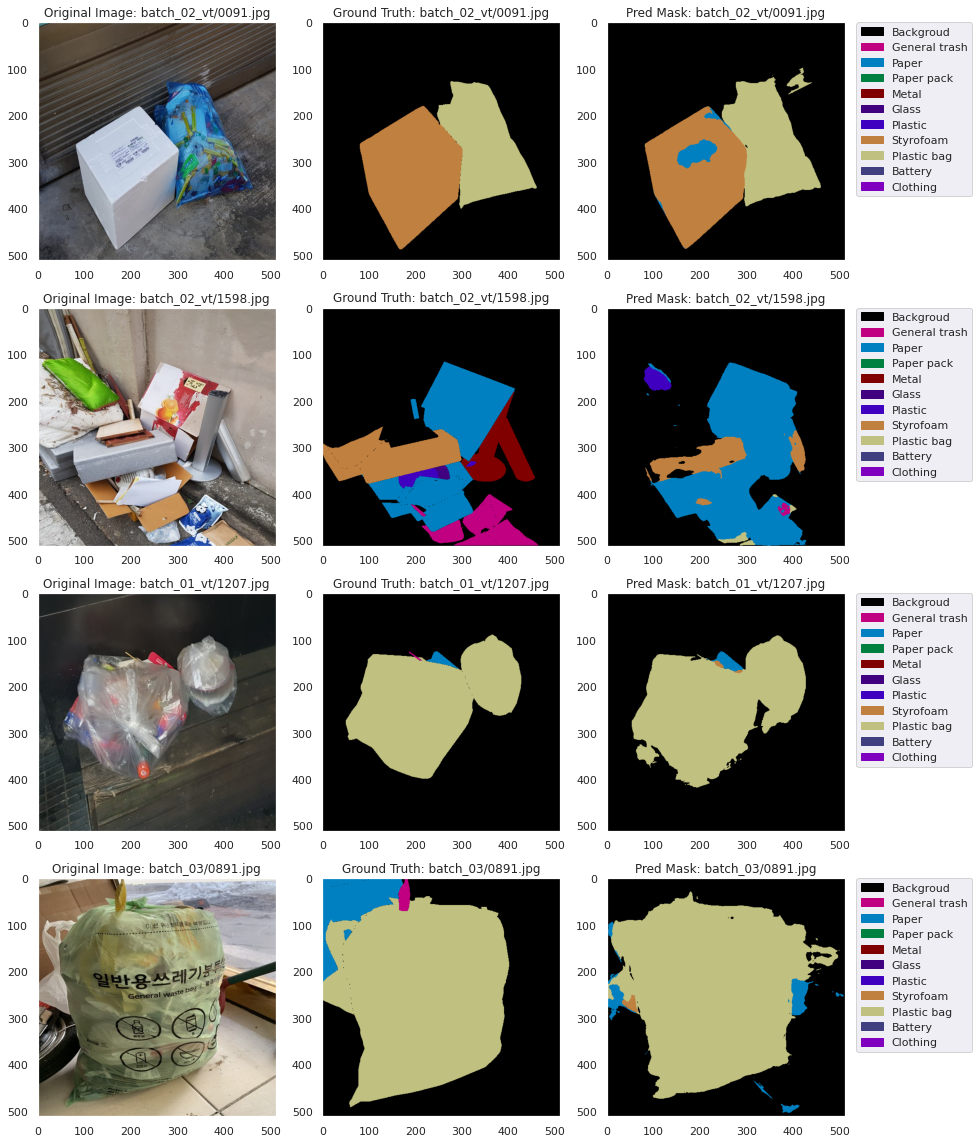

In [42]:
# train set

plot_examples(mode="train", batch_id=7, num_examples=batch_size, dataloader=train_loader)

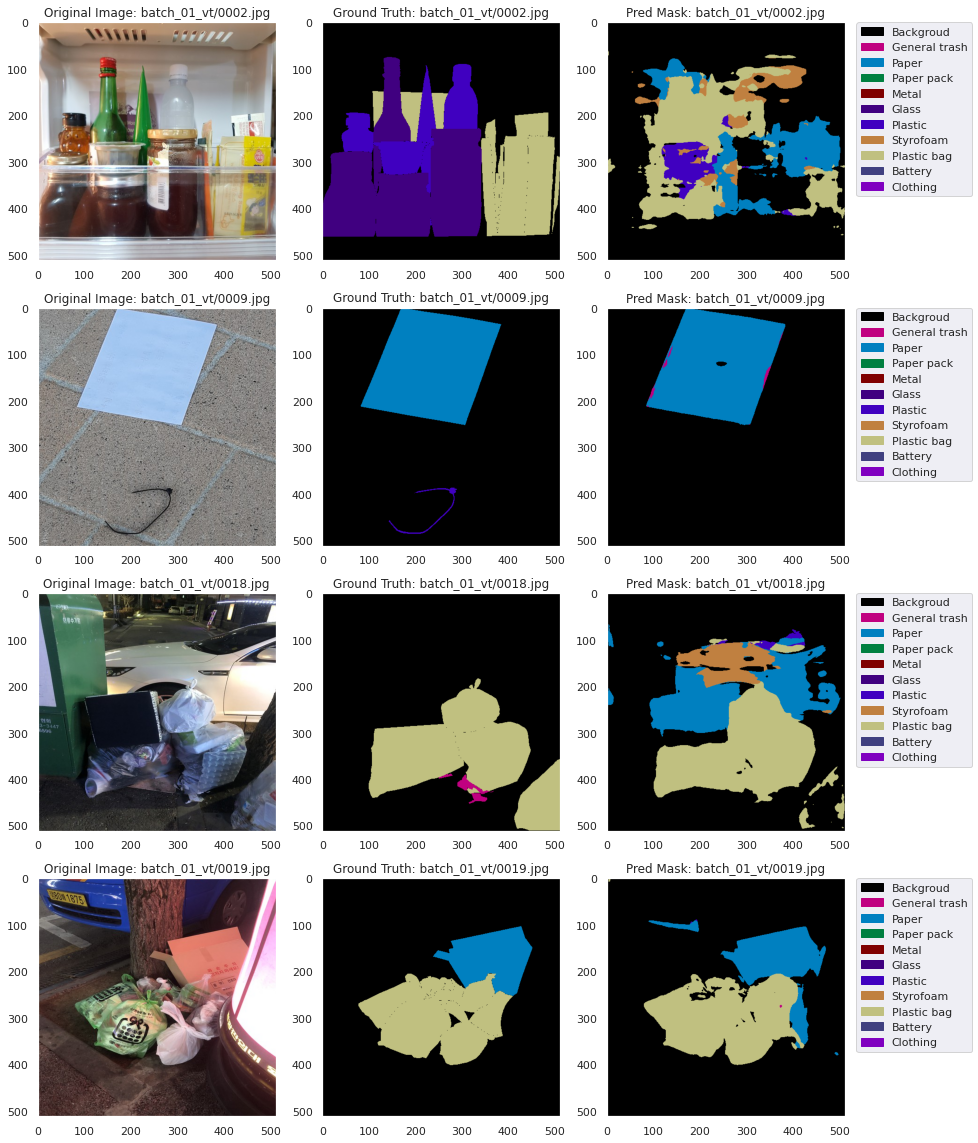

In [43]:
# validation set 

plot_examples(mode="val", batch_id=0, num_examples=batch_size, dataloader=val_loader)

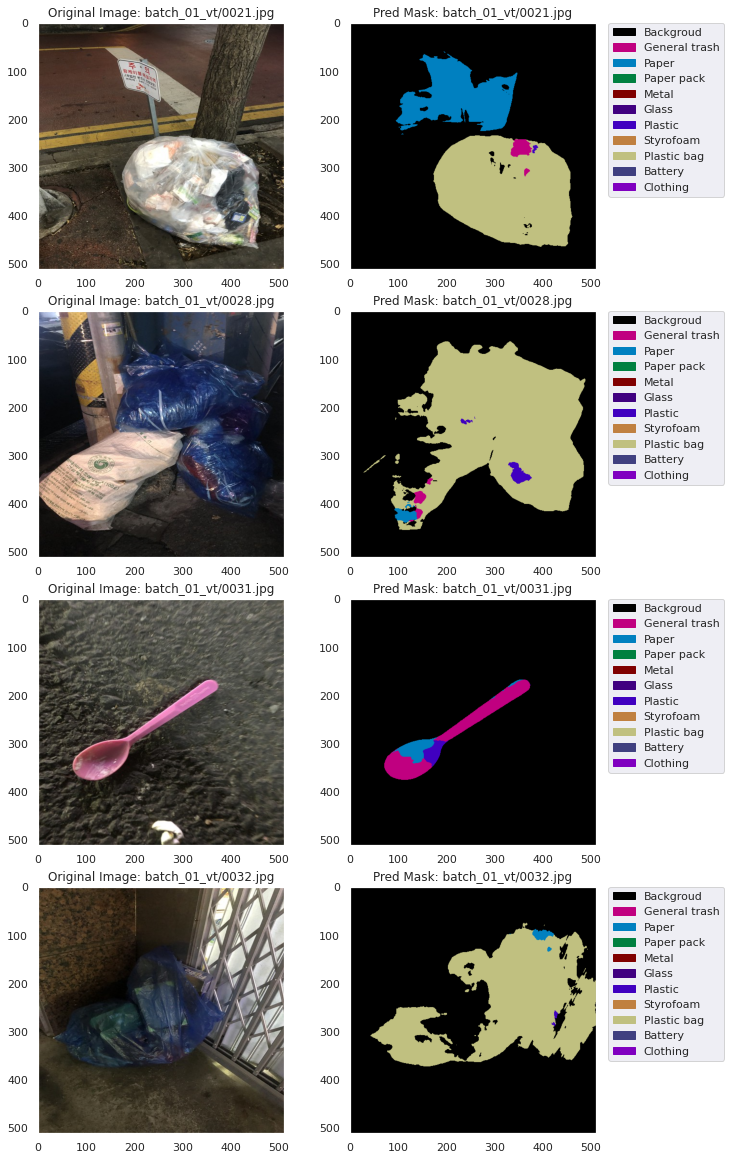

In [44]:
# test set

plot_examples(mode="test", batch_id=0, num_examples=batch_size, dataloader=test_loader)

In [47]:
def test(model, data_loader, device):
    
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    
    print('Start prediction')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (images, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference
            # outs = model(torch.stack(images).to(device))['out']
            outs = model(torch.stack(images).to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize
            temp_mask = []
            for image, mask in zip(np.stack(images), oms):
                transformed = transform(image=image, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
            
    print("End prediction")
    
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

In [49]:
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

file_names, preds = test(model, test_loader, device)

for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, ignore_index=True)
    
submission.to_csv("./submission/unet3plus_best_model.csv", index=False)

  0%|          | 0/156 [00:00<?, ?it/s]

Start prediction


100%|██████████| 156/156 [06:49<00:00,  2.63s/it]


End prediction
